In [34]:
from rasterio.features import rasterize
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt

# Paths files
tif_POST = 'Data/GLCM POST.tif'
tif_PRE = 'Data/GLCM PRE.tif'

scratch_dir = './scratch' 

def print_band_info(tif_file):
    with rasterio.open(tif_file) as src:
        print(f"Information for: {tif_file}")
        print(f"Number of bands: {src.count}")
        for i in range(1, src.count + 1):
            band = src.read(i)
            print(f"Band {i} shape: {band.shape}")
        print("-" * 40)

# Print available bands
print_band_info(tif_PRE)
print_band_info(tif_POST)


Information for: Data/GLCM PRE.tif
Number of bands: 10
Band 1 shape: (392, 537)
Band 2 shape: (392, 537)
Band 3 shape: (392, 537)
Band 4 shape: (392, 537)
Band 5 shape: (392, 537)
Band 6 shape: (392, 537)
Band 7 shape: (392, 537)
Band 8 shape: (392, 537)
Band 9 shape: (392, 537)
Band 10 shape: (392, 537)
----------------------------------------
Information for: Data/GLCM POST.tif
Number of bands: 10
Band 1 shape: (392, 537)
Band 2 shape: (392, 537)
Band 3 shape: (392, 537)
Band 4 shape: (392, 537)
Band 5 shape: (392, 537)
Band 6 shape: (392, 537)
Band 7 shape: (392, 537)
Band 8 shape: (392, 537)
Band 9 shape: (392, 537)
Band 10 shape: (392, 537)
----------------------------------------


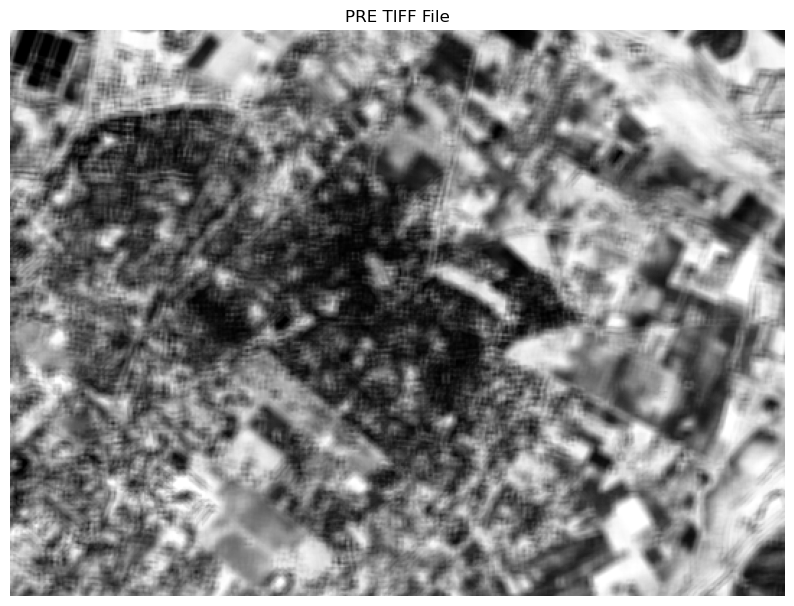

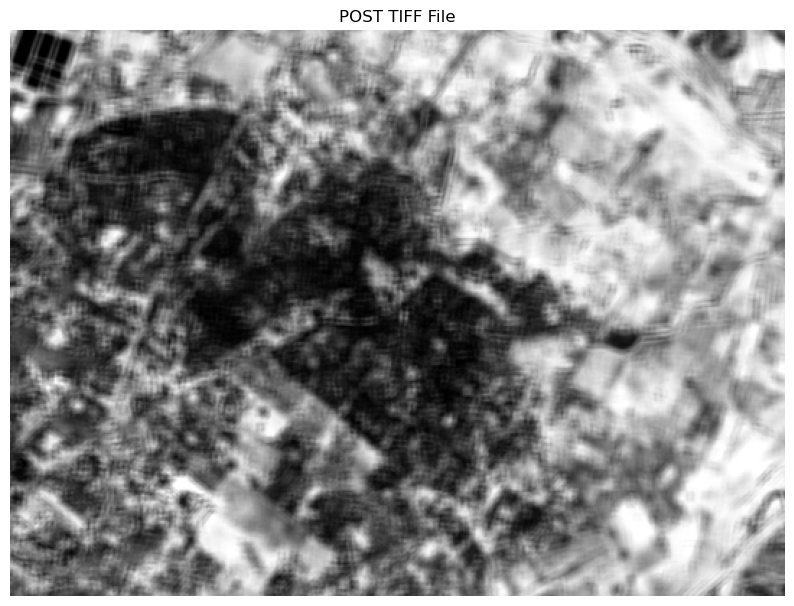

In [35]:
def display_band(tif_file, title, band_number):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least x bands
        if src.count < band_number:
            print(f"File {tif_file} does not have 8 bands.")
            return

        band = src.read(band_number)

        plt.figure(figsize=(10, 10))
        plt.imshow(band, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

display_band(tif_PRE, "PRE TIFF File", 8)
display_band(tif_POST, "POST TIFF File", 8)

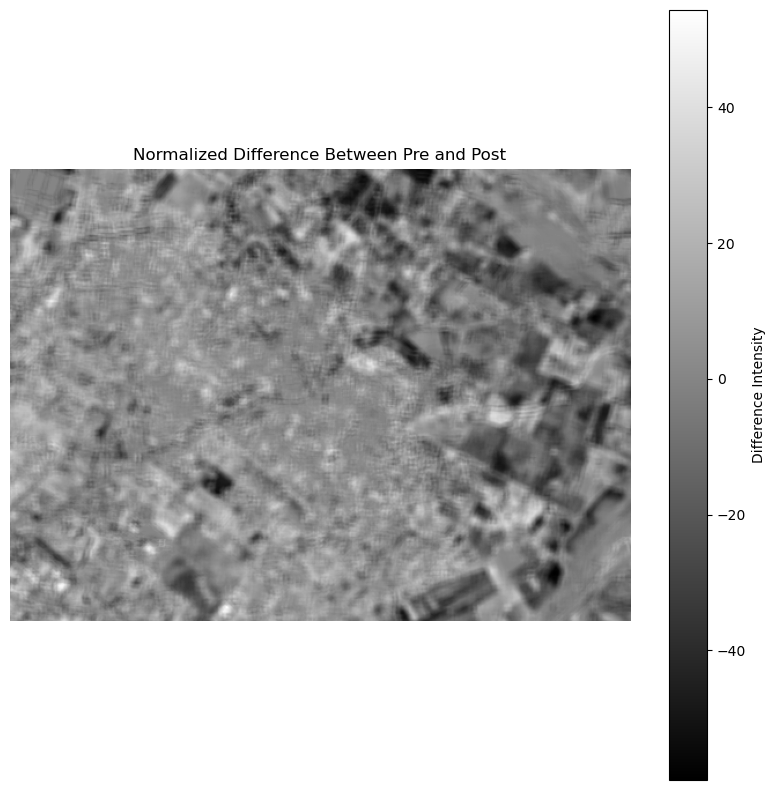

Image saved to: ./scratch/Normalized_difference.tif


In [36]:
def read_band(tif_file, band_nr):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least 8 bands
        if src.count < band_nr:
            print(f"File {tif_file} does not have 8 bands.")
            return None
        # Read the 8th band
        band = src.read(band_nr)
        return band

# Read the 8th band from both files
band_Pre = read_band(tif_PRE, 8)
band_Post = read_band(tif_POST, 8)

if band_Pre is not None and band_Post is not None:
    # Check if the bands have the same shape
    if band_Pre.shape != band_Post.shape:
        print("The bands of the two files do not have the same shape.")
    else:
        # Compute the difference
        difference = band_Pre - band_Post

        # Display the difference image
        plt.figure(figsize=(10, 10))
        plt.imshow(difference, cmap='gray')
        plt.title("Normalized Difference Between Pre and Post")
        plt.axis('off')  # Hide the axes
        plt.colorbar(label='Difference Intensity')
        plt.show()

        # Use the metadata of the first file as a template for the output file
        with rasterio.open(tif_PRE) as src:
            meta = src.meta
        meta.update(count=1)

        output_tif = f"Normalized_difference.tif"
        output_tif = os.path.join(scratch_dir, output_tif)

        # Write the difference image to a new TIFF file
        with rasterio.open(output_tif, 'w', **meta) as dst:
            dst.write(difference, 1)

        print(f"Image saved to: {output_tif}")


In [ ]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

with rasterio.open('Scratch/Normalized_difference.tif') as src:
    difference_image = src.read(1)
    difference_affine = src.transform

shapefile = gpd.read_file('/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp')

# Rasterize the shapefile, use fill=-1 to make areas that are not buildings transparent
def rasterize_shapefile(shapefile, affine, shape):
    shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['damaged'].astype(int)))
    rasterized = rasterize(shapes=shapes, out_shape=shape, transform=affine, fill=-1, all_touched=True, dtype=rasterio.int16)
    return rasterized

rasterized_shapefile = rasterize_shapefile(shapefile, difference_affine, difference_image.shape)

cmap = mcolors.ListedColormap(['none', 'green', 'red'])
bounds = [-1, 0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(15, 15))
plt.imshow(rasterized_shapefile, cmap=cmap, norm=norm)
plt.title("Building Damage Classification")
plt.axis('off')

# Create custom color bar
not_damaged_patch = mpatches.Patch(color='green', label='Not Damaged')
damaged_patch = mpatches.Patch(color='red', label='Damaged')

plt.legend(handles=[not_damaged_patch, damaged_patch], bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0., fontsize='large')

plt.show()

In [ ]:
def compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds):
    best_threshold = None
    best_f1 = -np.inf  # Initialize with a very low F1 score
    best_accuracy = -np.inf  # Initialize with a very low accuracy

    for threshold in thresholds:
        # Apply threshold to the entire difference image to classify as damaged (1) or not damaged (0)
        classified_image = np.where(difference_image > threshold, 1, 0)

        # Mask the classified image to include only building areas, set non-building areas to -1
        masked_classified_image = np.where(rasterized_shapefile == 1, classified_image, -1)

        # Flatten arrays for metrics calculation
        true_values = rasterized_shapefile.flatten()
        predicted_values = masked_classified_image.flatten()

        # Remove values from areas outside buildings (-1 in both rasterized_shapefile and masked_classified_image)
        valid_mask = (true_values != -1) & (predicted_values != -1)
        true_values = true_values[valid_mask]
        predicted_values = predicted_values[valid_mask]

        # Calculate metrics for binary classification, ensuring only building areas are considered
        accuracy = accuracy_score(true_values, predicted_values)
        f1 = f1_score(true_values, predicted_values, average='binary', zero_division=0)

        # Update the best threshold based on F1 score and accuracy
        if f1 > best_f1 and accuracy > best_accuracy:
            best_f1 = f1
            best_accuracy = accuracy
            best_threshold = threshold

        print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    print(f"\nBest Threshold: {best_threshold:.2f} with Accuracy: {best_accuracy:.4f}, F1 Score: {best_f1:.4f}")

    # Optional: Visualize the classification at the best threshold
    # This part can be moved outside the function if you prefer
    best_classified_image = np.where(difference_image > best_threshold, 1, 0)
    best_masked_classified_image = np.where(rasterized_shapefile == 1, best_classified_image, -1)
    cmap = mcolors.ListedColormap(['none', 'green', 'red'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    plt.figure(figsize=(10, 10))
    plt.imshow(best_masked_classified_image, cmap=cmap, norm=norm)
    plt.title(f"Best Classification at Threshold: {best_threshold:.2f}")
    plt.axis('off')
    plt.legend(handles=[mpatches.Patch(color='green', label='Not Damaged'), mpatches.Patch(color='red', label='Damaged')], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

thresholds = np.linspace(difference_image.min(), difference_image.max(), 50)
# Compute metrics for each threshold and visualize the best result
compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds)



In [ ]:
def compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds):
    for threshold in thresholds:
        # Apply threshold to the entire difference image to classify as damaged (1) or not damaged (0)
        classified_image = np.where(difference_image > threshold, 1, 0)

        # Mask the classified image to include only building areas, set non-building areas to -1
        masked_classified_image = np.where(rasterized_shapefile == 1, classified_image, -1)

        # Flatten arrays for metrics calculation
        true_values = rasterized_shapefile.flatten()
        predicted_values = masked_classified_image.flatten()

        # Remove values from areas outside buildings (-1 in both rasterized_shapefile and masked_classified_image)
        valid_mask = (true_values != -1) & (predicted_values != -1)
        true_values = true_values[valid_mask]
        predicted_values = predicted_values[valid_mask]

        # Calculate metrics for binary classification, ensuring only building areas are considered
        accuracy = accuracy_score(true_values, predicted_values)
        precision = precision_score(true_values, predicted_values, average='binary', zero_division=0)
        recall = recall_score(true_values, predicted_values, average='binary')
        f1 = f1_score(true_values, predicted_values, average='binary')

        print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        
        # Visualization: Use a custom colormap to display building areas
        cmap = mcolors.ListedColormap(['none', 'green', 'red'])  # 'none' for -1, 'green' for 0, 'red' for 1
        bounds = [-1.5, -0.5, 0.5, 1.5]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        plt.figure(figsize=(10, 10))
        plt.imshow(masked_classified_image, cmap=cmap, norm=norm)
        plt.title(f"Map at Threshold: {threshold:.2f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        plt.axis('off')
        # Custom legend for visualization
        plt.legend(handles=[mpatches.Patch(color='green', label='Not Damaged'), mpatches.Patch(color='red', label='Damaged')], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


# Define a range of threshold values to test
thresholds = np.linspace(difference_image.min(), difference_image.max(), num=50)
# Compute metrics for each threshold
compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds):
    # Pre-calculate the mask for building areas and flatten it for efficient computation
    building_mask = rasterized_shapefile == 1
    flat_building_mask = building_mask.flatten()

    # Pre-calculate the flat difference image to avoid repeated flattening
    flat_difference_image = difference_image.flatten()

    # Iterate through each threshold to classify and compute metrics
    for threshold in thresholds:
        # Apply threshold and flatten the classified image
        flat_classified_image = np.where(flat_difference_image > threshold, 1, 0)

        # Use the pre-calculated building mask to filter out non-building areas
        valid_indices = np.where(flat_building_mask)
        true_values = flat_building_mask[valid_indices]
        predicted_values = flat_classified_image[valid_indices]

        # Calculate metrics for binary classification within building areas
        accuracy = accuracy_score(true_values, predicted_values)
        precision = precision_score(true_values, predicted_values, zero_division=0)
        recall = recall_score(true_values, predicted_values)
        f1 = f1_score(true_values, predicted_values)
        
        # For 'Not Damaged' as the positive class
        precision_not_damaged = precision_score(true_values, predicted_values, pos_label=0, zero_division=0)
        recall_not_damaged = recall_score(true_values, predicted_values, pos_label=0)
        f1_not_damaged = f1_score(true_values, predicted_values, pos_label=0)
        
        print(f"Precision (Not Damaged): {precision_not_damaged:.4f}")
        print(f"Recall (Not Damaged): {recall_not_damaged:.4f}")
        print(f"F1 Score (Not Damaged): {f1_not_damaged:.4f}")


        print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # Visualization: Adjust the visualization to be more efficient
        masked_classified_image = np.full(difference_image.shape, -1)  # Initialize with -1 for non-building areas
        masked_classified_image[building_mask] = flat_classified_image[valid_indices]  # Update only building areas
        visualize_classification(masked_classified_image, threshold, accuracy, precision, recall, f1)

def visualize_classification(classified_image, threshold, accuracy, precision, recall, f1):
    cmap = mcolors.ListedColormap(['none', 'green', 'red'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10, 10))
    plt.imshow(classified_image, cmap=cmap, norm=norm)
    plt.title(f"Map at Threshold: {threshold:.2f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    plt.axis('off')
    plt.legend(handles=[mpatches.Patch(color='green', label='Not Damaged'), mpatches.Patch(color='red', label='Damaged')], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


thresholds = np.linspace(difference_image.min(), difference_image.max(), num=50)
compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds)


In [70]:
from sklearn.metrics import f1_score

def compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds):
    optimal_threshold = None
    max_min_f1 = 0  # Initialize the maximum of the minimum F1 scores

    for threshold in thresholds:
        classified_image = np.where(difference_image > threshold, 1, 0)
        masked_classified_image = np.where(rasterized_shapefile == 1, classified_image, -1)
        
        true_values = rasterized_shapefile.flatten()
        predicted_values = masked_classified_image.flatten()
        
        valid_mask = (true_values != -1) & (predicted_values != -1)
        true_values = true_values[valid_mask]
        predicted_values = predicted_values[valid_mask]

        f1_damaged = f1_score(true_values, predicted_values, pos_label=1, zero_division=0)
        f1_not_damaged = f1_score(true_values, predicted_values, pos_label=0, zero_division=0)
        min_f1 = min(f1_damaged, f1_not_damaged)

        # Debug print statements
        print(f"Threshold: {threshold}, F1 Damaged: {f1_damaged}, F1 Not Damaged: {f1_not_damaged}, Min F1: {min_f1}")

        if min_f1 > max_min_f1:
            max_min_f1 = min_f1
            optimal_threshold = threshold

    return optimal_threshold, max_min_f1

# Ensure 'difference_image', 'rasterized_shapefile', and 'thresholds' are defined
# optimal_threshold, max_min_f1 = compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds)
# print(f"Optimal Threshold: {optimal_threshold}, Maximum of Minimum F1 Score: {max_min_f1}")


# Example usage
thresholds = np.linspace(difference_image.min(), difference_image.max(), num=50)
optimal_threshold, max_min_f1 = compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds)
print(f"Optimal Threshold: {optimal_threshold}, Maximum of Minimum F1 Score: {max_min_f1}")



Threshold: -59.08333206176758, F1 Damaged: 1.0, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -56.768706263328085, F1 Damaged: 1.0, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -54.45408046488859, F1 Damaged: 1.0, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -52.1394546664491, F1 Damaged: 1.0, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -49.824828868009604, F1 Damaged: 1.0, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -47.51020306957011, F1 Damaged: 1.0, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -45.19557727113062, F1 Damaged: 1.0, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -42.88095147269112, F1 Damaged: 0.9999659063789165, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -40.56632567425163, F1 Damaged: 0.9999318104330037, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -38.251699875812136, F1 Damaged: 0.9998295086439117, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -35.93707407737264, F1 Damaged: 0.9996248422632243, F1 Not Damaged: 0.0, Min F1: 0.0
Threshold: -33.62244827893315, F1 Damaged: 0.99

In [69]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds):
    optimal_threshold = None
    max_min_f1 = 0  # Initialize the maximum of the minimum F1 scores

    for threshold in thresholds:
        # Apply threshold to the entire difference image to classify as damaged (1) or not damaged (0)
        classified_image = np.where(difference_image > threshold, 1, 0)

        # Mask the classified image to include only building areas, set non-building areas to -1
        masked_classified_image = np.where(rasterized_shapefile == 1, classified_image, -1)

        # Flatten arrays for metrics calculation
        true_values = rasterized_shapefile.flatten()
        predicted_values = masked_classified_image.flatten()

        # Remove values from areas outside buildings (-1 in both rasterized_shapefile and masked_classified_image)
        valid_mask = (true_values != -1) & (predicted_values != -1)
        true_values = true_values[valid_mask]
        predicted_values = predicted_values[valid_mask]

        # Calculate F1 scores for both classes
        f1_damaged = f1_score(true_values, predicted_values, pos_label=1, zero_division=0)
        f1_not_damaged = f1_score(true_values, predicted_values, pos_label=0, zero_division=0)
        min_f1 = min(f1_damaged, f1_not_damaged)

        # Update optimal threshold if the current minimum F1 is the best so far
        if min_f1 > max_min_f1:
            max_min_f1 = min_f1
            optimal_threshold = threshold

        

    return optimal_threshold, max_min_f1

# Example usage
thresholds = np.linspace(difference_image.min(), difference_image.max(), num=50)
optimal_threshold, max_min_f1 = compute_metrics_at_thresholds(difference_image, rasterized_shapefile, thresholds)
print(f"Optimal Threshold: {optimal_threshold}, Maximum of Minimum F1 Score: {max_min_f1}")


Optimal Threshold: None, Maximum of Minimum F1 Score: 0


In [71]:
import geopandas as gpd
import rasterio

shapefile_path = '/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp'
polygons = gpd.read_file(shapefile_path)

# Load your raster (difference image)
raster_path = 'Scratch/Normalized_difference.tif'
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Read the first band into a 2D array
    raster_meta = src.meta

In [73]:
# Assuming 'IsDamaged' is the column indicating damage status (1 for damaged, 0 for not)
damaged_polygons = polygons[polygons['damaged'] == 1]
not_damaged_polygons = polygons[polygons['damaged'] == 0]


In [74]:
from rasterio.mask import mask

def get_masked_raster(raster_src, shapes):
    masked_raster, masked_transform = mask(dataset=raster_src, shapes=shapes, crop=True)
    return masked_raster[0]  # Assuming you're interested in the first band

# Ensure CRS match between raster and shapefile, reproject if necessary
damaged_polygons = damaged_polygons.to_crs(raster_meta['crs'])

with rasterio.open(raster_path) as src:
    masked_raster = get_masked_raster(src, damaged_polygons['geometry'])
    
not_damaged_polygons = not_damaged_polygons.to_crs(raster_meta['crs'])

# Masking for "Not Damaged"
with rasterio.open(raster_path) as src:
    masked_raster_not_damaged = get_masked_raster(src, not_damaged_polygons['geometry'])



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import geopandas as gpd
import rasterio
from rasterio import features

# Load the shapefile containing damaged and not damaged areas
shapefile = gpd.read_file('/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp')

# Filter polygons based on 'damaged' attribute
damaged_areas = shapefile[shapefile['damaged'] == 1]  # Assuming 'damaged' is a column indicating damaged areas
not_damaged_areas = shapefile[shapefile['damaged'] == 0]  # Assuming 'damaged' is a column indicating not damaged areas

# Load the raster image for reference
with rasterio.open('Scratch/Normalized_difference.tif') as src:
    difference_image = src.read(1)
    difference_affine = src.transform
    shape = difference_image.shape

# Rasterize the damaged areas
def rasterize_shapefile(shapefile, affine, shape):
    shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['damaged'].astype(int)))
    rasterized = features.rasterize(shapes=shapes, out_shape=shape, transform=affine, fill=-1, all_touched=True, dtype=rasterio.int16)
    return rasterized

rasterized_damaged = rasterize_shapefile(damaged_areas, difference_affine, shape)
rasterized_not_damaged = rasterize_shapefile(not_damaged_areas, difference_affine, shape)


def compute_metrics_at_thresholds(difference_image, rasterized_damaged, rasterized_not_damaged, thresholds):
    # Flatten the difference image for efficient computation
    flat_difference_image = difference_image.flatten()

    # Flatten and prepare the true values based on the damaged and not damaged masks
    true_values_damaged = np.full_like(flat_difference_image, -1)  # Initialize with -1 for areas not considered
    true_values_damaged[rasterized_damaged.flatten() == 1] = 1  # Mark damaged areas as 1

    true_values_not_damaged = np.full_like(flat_difference_image, -1)  # Initialize with -1 for areas not considered
    true_values_not_damaged[rasterized_not_damaged.flatten() == 1] = 0  # Mark not damaged areas as 0

    # Combine the true values
    true_values = np.where(true_values_damaged != -1, true_values_damaged, true_values_not_damaged)
    valid_mask = true_values != -1  # Mask to filter out -1 values

    for threshold in thresholds:
        # Apply threshold to classify as damaged (1) or not damaged (0)
        predicted_values = np.where(flat_difference_image > threshold, 1, 0)

        # Filter both true and predicted values based on the valid mask
        filtered_true_values = true_values[valid_mask]
        filtered_predicted_values = predicted_values[valid_mask]

        # Calculate metrics for binary classification
        accuracy = accuracy_score(filtered_true_values, filtered_predicted_values)
        precision = precision_score(filtered_true_values, filtered_predicted_values, zero_division=0)
        recall = recall_score(filtered_true_values, filtered_predicted_values)
        f1 = f1_score(filtered_true_values, filtered_predicted_values)

        print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # Visualization: Use a custom colormap to display building areas
        visualize_classification(predicted_values.reshape(difference_image.shape), threshold, accuracy, precision, recall, f1)

def visualize_classification(classified_image, threshold, accuracy, precision, recall, f1):
    cmap = mcolors.ListedColormap(['none', 'green', 'red'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10, 10))
    plt.imshow(classified_image, cmap=cmap, norm=norm)
    plt.title(f"Map at Threshold: {threshold:.2f}, Acc: {accuracy:.4f}, Prec: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    plt.axis('off')
    plt.legend(handles=[mpatches.Patch(color='green', label='Not Damaged'), mpatches.Patch(color='red', label='Damaged')], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

#Usage example (make sure difference_image, rasterized_damaged, rasterized_not_damaged, and thresholds are defined)
thresholds = np.linspace(difference_image.min(), difference_image.max(), num=50)
compute_metrics_at_thresholds(difference_image, rasterized_damaged, rasterized_not_damaged, thresholds)


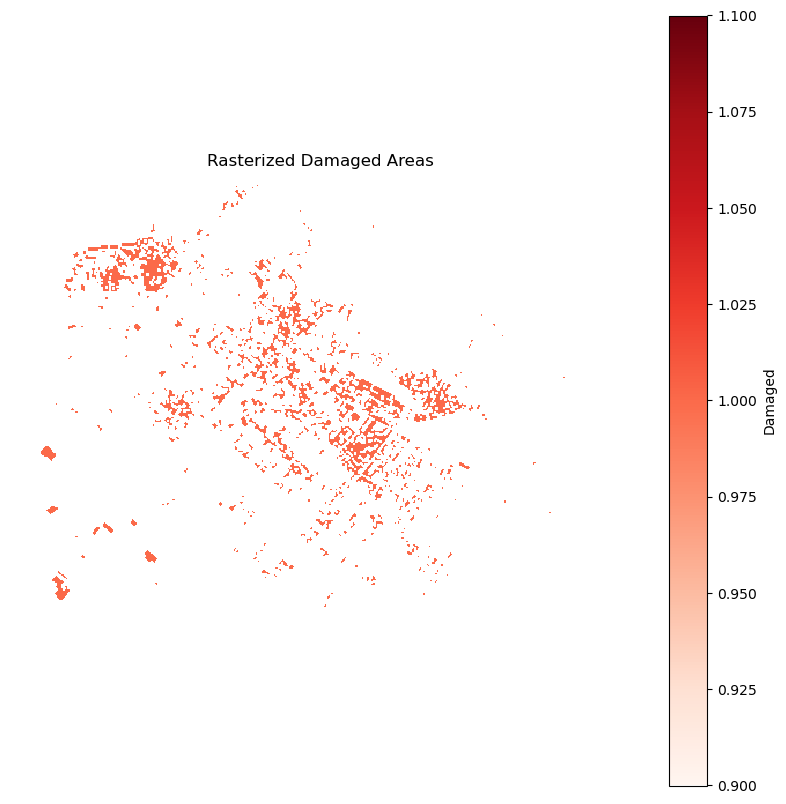

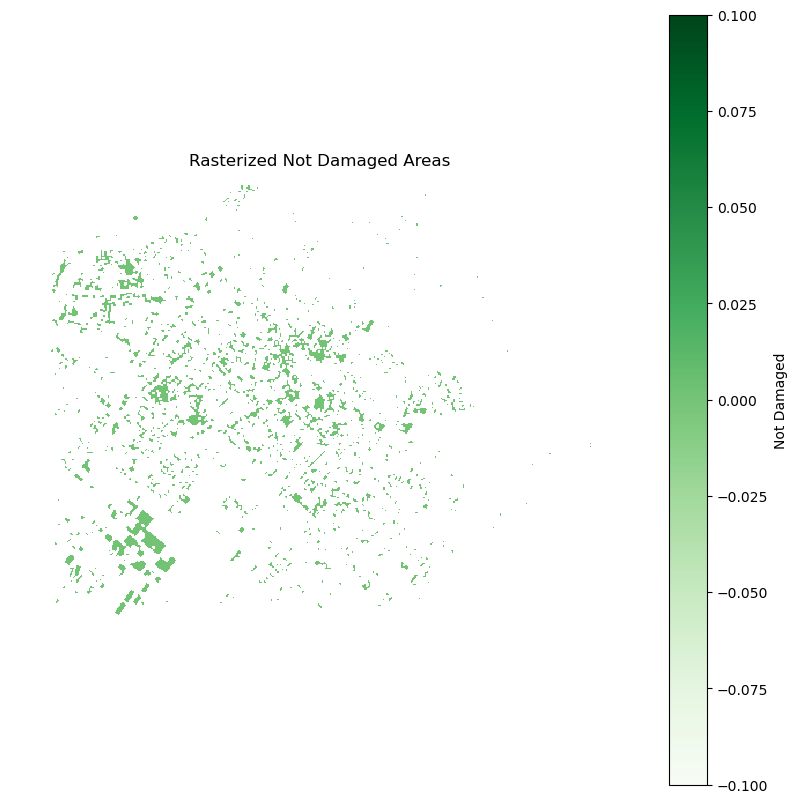

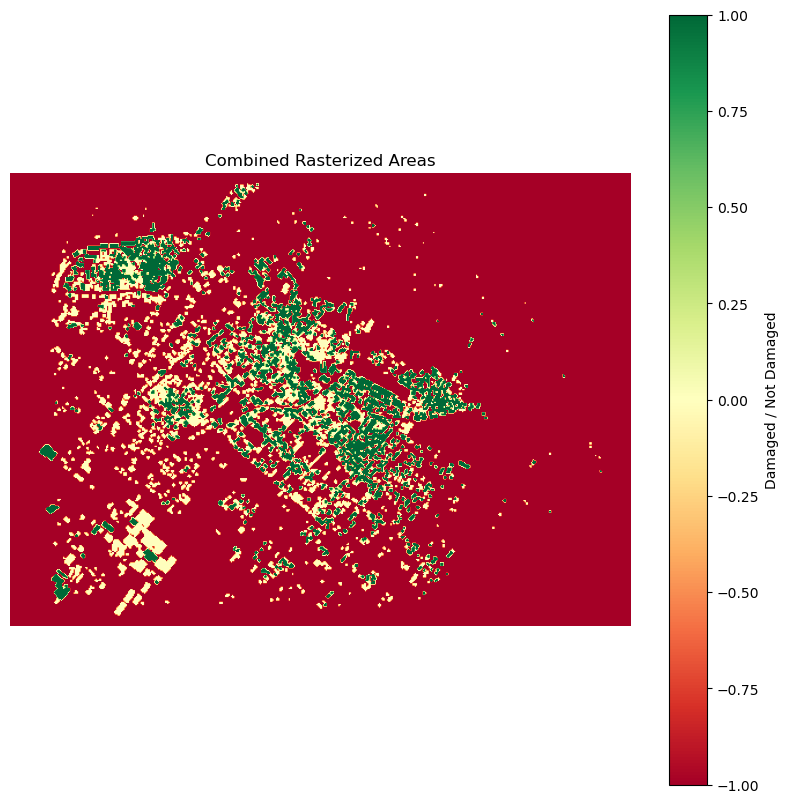

In [86]:
# Rasterize the damaged areas
def rasterize_shapefile(shapefile, affine, shape):
    shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['damaged'].astype(int)))
    rasterized = features.rasterize(shapes=shapes, out_shape=shape, transform=affine, fill=-1, all_touched=True, dtype=rasterio.int16)
    return rasterized

rasterized_damaged_true = np.where(rasterized_damaged >= 0, rasterized_damaged, np.nan)

# Filter out negative values from rasterized not damaged areas
rasterized_not_damaged_true = np.where(rasterized_not_damaged >= 0, rasterized_not_damaged, np.nan)

# Plot rasterized damaged areas
plt.figure(figsize=(10, 10))
plt.imshow(rasterized_damaged_true, cmap='Reds')  # Adjust the colormap as needed
plt.title('Rasterized Damaged Areas')
plt.colorbar(label='Damaged')
plt.axis('off')
plt.show()

# Plot rasterized not damaged areas
plt.figure(figsize=(10, 10))
plt.imshow(rasterized_not_damaged_true, cmap='Greens')  # Adjust the colormap as needed
plt.title('Rasterized Not Damaged Areas')
plt.colorbar(label='Not Damaged')
plt.axis('off')
plt.show()

In [90]:
import rasterio
from sklearn.metrics import accuracy_score

def rasterize_shapefile(shapefile, affine, shape):
    shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile['damaged'].astype(int)))
    rasterized = features.rasterize(shapes=shapes, out_shape=shape, transform=affine, fill=-1, all_touched=True, dtype=rasterio.int16)
    return rasterized

rasterized_damaged_true = np.where(rasterized_damaged >= 0, rasterized_damaged, np.nan)
rasterized_not_damaged_true = np.where(rasterized_not_damaged >= 0, rasterized_not_damaged, np.nan)

# Load the GLCM difference map
with rasterio.open('Scratch/Normalized_difference.tif') as src:
    glcm_difference_map = src.read(1)

# Flatten the GLCM difference map and the rasterized damaged/not damaged areas
flat_glcm_difference_map = glcm_difference_map.flatten()
flat_rasterized_damaged = rasterized_damaged_true.flatten()
flat_rasterized_not_damaged = rasterized_not_damaged_true.flatten()

# Define a function to compute the number of correct classifications
def count_correct_classifications(glcm_map, damaged_mask, not_damaged_mask, threshold):
    # Apply threshold to the GLCM difference map
    predicted_damage = glcm_map >= threshold
    
    # Compute the number of correct classifications
    correct_damaged = np.sum(predicted_damage[damaged_mask])
    correct_not_damaged = np.sum(~predicted_damage[not_damaged_mask])
    
    return correct_damaged, correct_not_damaged

# Set a threshold for classifying damaged areas
threshold = 1  # Adjust as needed

# Compute the number of correct classifications
correct_damaged, correct_not_damaged = count_correct_classifications(flat_glcm_difference_map, 
                                                                    flat_rasterized_damaged != np.nan, 
                                                                    flat_rasterized_not_damaged != np.nan, 
                                                                    threshold)

print("Correctly classified damaged areas:", correct_damaged)
print("Correctly classified not damaged areas:", correct_not_damaged)

# Compute overall accuracy
total_damaged = np.sum(~np.isnan(flat_rasterized_damaged))
total_not_damaged = np.sum(~np.isnan(flat_rasterized_not_damaged))
total_samples = total_damaged + total_not_damaged
accuracy = (correct_damaged + correct_not_damaged) / total_samples

print("Overall accuracy:", accuracy)




Correctly classified damaged areas: 104283
Correctly classified not damaged areas: 106221
Overall accuracy: 6.354262255493842


In [91]:
import rasterio
import geopandas as gpd
from rasterio import features
import numpy as np

def rasterize_polygons(shapefile, affine, shape):
    rasterized = np.zeros(shape, dtype=np.uint8)
    for idx, geom in enumerate(shapefile.geometry):
        value = shapefile.iloc[idx]['damaged']
        mask = features.geometry_mask([geom], out_shape=shape, transform=affine, invert=True)
        rasterized[mask] = value
    return rasterized

# Load the shapefile containing damaged and not damaged areas
shapefile = gpd.read_file('/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp')

# Load the GLCM difference map
with rasterio.open('Scratch/Normalized_difference.tif') as src:
    glcm_difference_map = src.read(1)
    affine = src.transform
    shape = glcm_difference_map.shape

# Rasterize the polygons
rasterized_polygons = rasterize_polygons(shapefile, affine, shape)

# Define a threshold for classification
threshold = 1

# Classify the polygons based on the GLCM difference map
predicted_damage = glcm_difference_map >= threshold

# Compute the number of correct classifications
correct_damaged = np.sum(predicted_damage[rasterized_polygons == 1])
correct_not_damaged = np.sum(~predicted_damage[rasterized_polygons == 0])

# Compute overall accuracy
total_damaged = np.sum(rasterized_polygons == 1)
total_not_damaged = np.sum(rasterized_polygons == 0)
total_samples = total_damaged + total_not_damaged
accuracy = (correct_damaged + correct_not_damaged) / total_samples

print("Correctly classified damaged areas:", correct_damaged)
print("Correctly classified not damaged areas:", correct_not_damaged)
print("Overall accuracy:", accuracy)


Correctly classified damaged areas: 3999
Correctly classified not damaged areas: 103723
Overall accuracy: 0.5117337437768403
